In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_08 import *

# Get imagenette data

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

# Get model

In [5]:
nfs = [32,64,128,256]

cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [6]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
run.fit(1, learn)

train: [1.7997466723863813, tensor(0.3747, device='cuda:0')]
valid: [1.5191533203125, tensor(0.4900, device='cuda:0')]


# One optimizer to rule them all

## Rewrite pytorch optimizer

In PyTorch, the **base optimizer in torch.optim is just a dictionary** that stores the hyper-parameters and references to the parameters of the model we want to train in parameter groups (different groups can have different learning rates/momentum/weight decay... which is what lets us do discriminative learning rates).

It **contains a method step that will update our parameters** with the gradients and a method **zero_grad to detach and zero the gradients of all our parameters**.



```python
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x
```

In [8]:
class Optimizer():
    # might be a generator
    def __init__(self, params, steppers, **defaults):
        # - params: a list of list, e.g. params= model.parameters() -> [[<layer1_params>,<layer2_params>,...]] #1 group
        #     outer lists are for groups, inner lists are for layers in that group (params)
        # - defaults: default value of hyperparams, e.g. {'lr': 0.1 , ...}
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
            
        self.hypers = [{**defaults} for p in self.param_groups] # e.g. [{'lr':0.1 , ...},{'lr':0.1 , ...}] for 2 groups
        # this will clone dict so each param groups can have different/unrelated dict
        
        self.steppers = listify(steppers)

    def grad_params(self):
        # actual weight params needed to be updated using optimizers
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]
        # [( <group1_layer1_params>,{'lr':0.1} ),...,( <group2_layer1_params>,{'lr':0.1} ),...]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_() #remove gradient computation history
            p.grad.zero_()

    def step(self):
        # apply list of stepper funcs on each layer params (weights) with hyperparams (e.g. lr) as func inputs
        # hyper is passed as kwargs in compose func (see cell above)
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)
        
        # e.g., if steppers is sgd_step, compose function will update p (weight) using p.grad and lr in **hyper
        # ignore output of compose

## SGD

In [9]:
def sgd_step(p, lr, **kwargs):
    # Note: use p.data instead of p to prevent gradient when updating weight
    p.data.add_(-lr, p.grad.data) # p.data= p.data - lr* p.grad.data
    return p

In [10]:
opt_func = partial(Optimizer, steppers=[sgd_step])

## rewrite some callbacks

```python
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[] 

    def after_batch(self): # save learning rate (of only last groups) and loss after training each batch
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr']) # get lr of last groups and append to lrs
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

```

In [11]:
# this only record last group param
class Recorder(Callback):
    def begin_fit(self):         
        self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

```python
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs): # different sched func for each group
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()
```

In [12]:
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): # put set_param in begin_batch
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
            
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): 
            h[self.pname] = f(pos)
   

In [13]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [14]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [15]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [16]:
#where our custom opt_func is used to initialize Optimizer
# opt = opt_func(model.parameters(), lr=lr)
??get_runner

In [17]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

# Check optimizer attributes

In [18]:
learn.opt

In [19]:
len(learn.opt.param_groups)

1

In [20]:
type(learn.opt.param_groups[0]),type(learn.opt.param_groups[0][0]),learn.opt.param_groups[0][0].shape

(list, torch.nn.parameter.Parameter, torch.Size([16, 3, 3, 3]))

In [21]:
learn.opt.hypers

[{'lr': 0.4}]

In [22]:
learn.opt.grad_params() # empty for now since no grad has been calculated. Will be populated once model runs batches

[]

In [23]:
%time run.fit(1, learn)

train: [1.7329271972429037, tensor(0.4056, device='cuda:0')]
valid: [1.31254248046875, tensor(0.5540, device='cuda:0')]
CPU times: user 3.13 s, sys: 1.46 s, total: 4.59 s
Wall time: 5.82 s


In [24]:
type(learn.opt.grad_params()[0][0]), learn.opt.grad_params()[0][1]

(torch.nn.parameter.Parameter, {'lr': 0.20019741842537647})

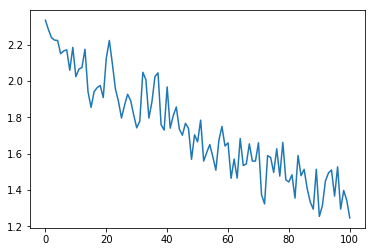

In [25]:

run.recorder.plot_loss()

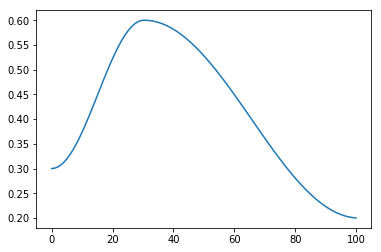

In [26]:

run.recorder.plot_lr()

# Weight decay vs L2 regularization

### Best definition/ intuition for L2 regularization

During gradient descent, our update step will look like:
$$ Loss(w,x) = DataLoss(w,x) +  c \frac{1}{2} ||w||^2 $$

$$ w:= w - \alpha \frac{d}{dw}Loss(w,x) $$

$$ w:= w - \alpha \frac{d}{dw}(DataLoss(w,x) + c \frac{1}{2} ||w||^2 $$

$$ w:= w - \alpha \frac{dDataLoss(w,x)}{dw} - \alpha cw $$

$$ w:= w(1- \alpha c) - \alpha \frac{dDataLoss(w,x)}{dw}$$

Each optimization step (in addition to stepping based on a gradient to better fit the training data), all model weights also **decay proportionally towards zero by a small factor of (1−αc)**. This is why this technique is also known as “weight decay”.

Weight decay will continuously **squeeze model weights to be too small, increasing error on the training data**. However, **important weights** that capture common regularities in the data **will consistently recover back up on future steps**, re-reducing that error. **Weight values that are merely due to noise in a particular batch (which can lead to overfitting)** or to only small numbers of data samples and that do not affect the error much **will not recover so readily**.

Limiting our weights from growing too much is going to hinder the training of the model, but it will yield to a state where it generalizes better

```new_weight = (weight - lr * weight.grad) - lr * wd * weight```

Weight decay is subtracting ```lr * wd * weight``` from the weights **after** doing the optimization step

In [27]:
dict(wd=0.)

{'wd': 0.0}

In [28]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd) # p.data = p.data - p.data*lr*wd
    return p
weight_decay._defaults = dict(wd=0.)
# note: you can add attributes to a function (because function in python is just an obj)

In [29]:
weight_decay._defaults

{'wd': 0.0}

L2 regularization: ```weight.grad += wd * weight```. Do this **before** doing optimization step

Then 
```
opt.step()
weight  = weight - lr*weight.grad
```

In [30]:
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data) # p.grad = p.grad + wd * p.data
    return p
l2_reg._defaults = dict(wd=0.)


In [31]:
def maybe_update(os, dest, f):
    # update dest (dictionary) with dictionary in each of o in os. Use function f to achieve dictionary from o 
    
    # In steppers optimizer concept: update defaults dictionary with _defaults dict items in steppers
    # why? because we want each stepper to have its own _default value so we don't have to put it in **defaults every time 
    # => need a function to unite them all into **defaults so we can flexibly pass it in different steppers via compose 
    
    # defaults: dict of hyperparam default value, e.g. {'lr':0.1}
    # If running this function on weight_decay steppers, defaults will now be {'lr':0.1,'wd': 0.0}
    # Also, **defaults value will override existing stepper's _defaults
    for o in os:
        for k,v in f(o).items():
            if k not in dest: dest[k] = v

def get_defaults(d): return getattr(d,'_defaults',{})

In [32]:
get_defaults(sgd_step),get_defaults(weight_decay),get_defaults(l2_reg)

({}, {'wd': 0.0}, {'wd': 0.0})

In [33]:
# only change: maybe_update
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [34]:
sgd_opt = partial(Optimizer, steppers=[sgd_step, weight_decay]) 
# since it's SGD so order of steppers is not important. Logically it should be [sgd_step, weight_decay]

In [35]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt) # we don't habe **defaults

In [36]:
model = learn.model

In [37]:
opt = sgd_opt(model.parameters(), lr=0.1)
opt.hypers

[{'lr': 0.1, 'wd': 0.0}]

In [38]:
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4) # override default
opt.hypers

[{'lr': 0.1, 'wd': 0.0001}]

## start training

In [39]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]

In [40]:
sgd_opt

functools.partial(<class '__main__.Optimizer'>, steppers=[<function sgd_step at 0x7fdc286a79d8>, <function weight_decay at 0x7fdc285fdd08>])

In [41]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=partial(sgd_opt, wd=0.01))

In [42]:
run.fit(1, learn)

train: [1.7997810573231736, tensor(0.3772, device='cuda:0')]
valid: [1.53408447265625, tensor(0.4940, device='cuda:0')]


# Momentum

We need to save the moving average of the gradients to be able to do the step and store this inside the optimizer state.

We will create Stat class with 2 methods:
    - init_state, that returns the initial state (a tensor of 0. for the moving average of gradients)
    - update, that updates the state with the new gradient value

In [43]:
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError

In [44]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data) 
        # moving_grad = moving_grad*mom + current_gradw 
        # note that this is the 'regular' momentum where current_gradw has 100% weight, 
        # not the 'smoothened' one with  (1-mom)*current_gradw
        return state

In [45]:
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg) # p.data= p.data+ lr*moving_grad
    return p

In [46]:
??compose

In [47]:
# new optimizer
class StatefulOptimizer(Optimizer): # inherit Optimizer for grad_params and zero_grad functions
    def __init__(self, params, steppers, stats=None, **defaults): 
        self.stats = listify(stats) # list of Stat children objects, e.g. [AverageGrad(), ...]
        # get mom default value into defaults dict
        maybe_update(self.stats, defaults, get_defaults) # {'lr':0.1,'mom':0.9}

        super().__init__(params, steppers, **defaults) # {'lr':0.1,'mom':0.9,'wd':0.}
        # Note: optimizer_step (momentum_step), member of steppers, does not have its own _default dict
        # However adam_step does (eps), hmmm....
        
        self.state = {}
        # a dictionary with {<nn weight>: {something related to nn_weight} }
        # {group1_layer1_nn_weight_param: {'grad_avg': group1_layer1_nn_moving_weight_grad,
        #                                 'sqr_avg': group1_layer1_nn_moving_weight_grad_squared, ...},
        #  group1_layer2_nn_weight_param: {'grad_avg': group1_layer2_nn_moving_weight_grad, ... }, 
        # }
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                #Create a state for p and call all the statistics to initialize it.
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
                
            state = self.state[p] # get {'grad_avg': group1_layer1_nn_moving_weight_grad,...}
            
            for stat in self.stats: 
                # update moving-weight-grad ('grad_avg') using each stat's update method
                state = stat.update(p, state, **hyper) # hyper dict will contain 'mom' value
                
            # apply list of stepper funcs on each param p (weight) with hyperparams (e.g. lr,wd, mom) as func inputs
            # We also pass moving-weight-grad {'grad_avg': group1_layer1_nn_moving_weight_grad,...} into compose func's **kwargs
            # in case some steppers need it 
            # (e.g. Momentum stepper needs 'grad_avg', Adam stepper needs that and 'sqr_avg' to update p (weight))
            compose(p, self.steppers, **state, **hyper)
            
            # save the new moving-weight-grad back to optimizer's state dictionary
            self.state[p] = state

In [48]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay],
                  stats=AverageGrad(), wd=0.01)

In [49]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)

In [50]:
run.fit(1, learn)

train: [1.8420896771269584, tensor(0.3637, device='cuda:0')]
valid: [2.39410546875, tensor(0.3000, device='cuda:0')]


# Shocking news: while batchnorm is presented, L2 regularization/weight decay no longer has it original effect! (Assuming SGD optimizer is used)

https://blog.janestreet.com/l2-regularization-and-batch-norm/

Recap:

- L2 reg intuition: weight decay will continuously squeeze model weights to be too small, increasing error on the training data. However, important weights that capture common regularities in the data will consistently recover back up on future steps, re-reducing that error. Weight values that are merely due to noise (overfit potential) in a particular batch or to only small numbers of data samples and that do not affect the error much will not recover so readily

-> the final model weights (hopefully) fit the more of the broader regularities in the data and less of the noise. This is how an L2 penalty regularizes the model.

- Batchnorm intuition: batch norm layers **make the neural net output approximately invariant to the scale of the activations of the previous layers (scale invariance)**. Any such scaling will simply be normalized away, except for the tiny effect of the ϵ in the denominator.

### What happens when both are used together

X: input -> L(W): output of conv_layer -> BN(W): output of batchnorm layer

Note that we don't have nonlinear activation, for now

![title](bn_l2_broken.PNG)


The weight decay from the L2 penalty on a convolutional layer no longer has its original influence (or has a totally different effect?) on the output of the neural net!

**Without batch norm, important weights should experience gradients to restore their magnitudes countering earlier weight decays**, whereas **weights fitting only noise would on average remain decayed**. But **with batch norm, all weights will be “equally happy” at the decayed value λw as at the original value**. 

Since it is a proportional decay, **the batch norm layer will automatically “undo” the decay** and there will be no gradient to preferentially increase the magnitude of the important entries within w relative to the less important ones.

### That's the effect on weight for forward pass, how about backward pass?

If a given function f(w) is invariant to multiplicative scalings of w (in this scenario f is BN and scaling of w is due to L2 λ), then **the direction of the gradient df/dw must also be invariant to multiplicative scalings of w**

-> weight decay’s scaling of the weights cannot directly alter the direction of future gradient descent steps to favor any components of w over any others

### How about the scaling of w GRADIENT when batchnorm is presented?

The gradients should vary inversely with λ. 

Scaling w by a factor of λ **causes the gradients to scale by a factor of 1/λ**. 

### Effect on learning rate


**Without batch norm, the weights of a well-behaving neural net usually don’t grow arbitrarily**, since an arbitrary scaling of all the weights will almost certainly worsen the data loss. In my experience, it’s pretty common for weights to remain near same order of magnitude that they were initialized at.

But **with batch norm, they are unconstrained since an increase in the overall magnitude of the weights in any layer will simply result in the subsequent batch norm layer scaling all the activations down again**. So the weights can grow significantly over time, and absent any controlling force in practice they very much do

Since **with batch norm** what matters is the scale of gradient steps relative to the existing magnitude of w, and w itself is still λ times larger, **this effectively scales the learning rate of w by a factor of 1/λ2.**

-> By the 1/λ^2 scaling of the gradient, this will in effect cause the learning rate to greatly decay over time

-> **So without an L2 penalty or other constraint on weight scale, introducing batch norm will introduce a large decay in the effective learning rate over time.**

-> **However, using L2 penalty counters this.** With an L2 penalty term to provide weight decay, the scale of w will be bounded (???)

### Conclusion

Once you are using batch normalization in a neural net, an **L2 objective penalty term or weight decay no longer contribute in any direct manner to the regularization of layers that *precede* a batch norm layer**. 

Instead, they **take on a new role** as the unique control that **prevents the EFFECTIVE LEARNING RATE from decaying over time**.


# Momentum in depth

Understand how momentum affects gradient

In [51]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3 # this is grad_w at different iteration
betas = [0.5, 0.7, 0.9, 0.99]

In [52]:
x[:5], x.shape,y[:5]

(tensor([-4.0000, -3.9598, -3.9196, -3.8794, -3.8392]),
 torch.Size([200]),
 tensor([ 0.3229, -1.0215, -0.2302,  0.4755,  1.4187]))

In [53]:
def plot_mom(f):
    _,axs = plt.subplots(2,2, figsize=(12,8))
    for beta,ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg,res = None,[]
        for i,yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

### Regular momentum

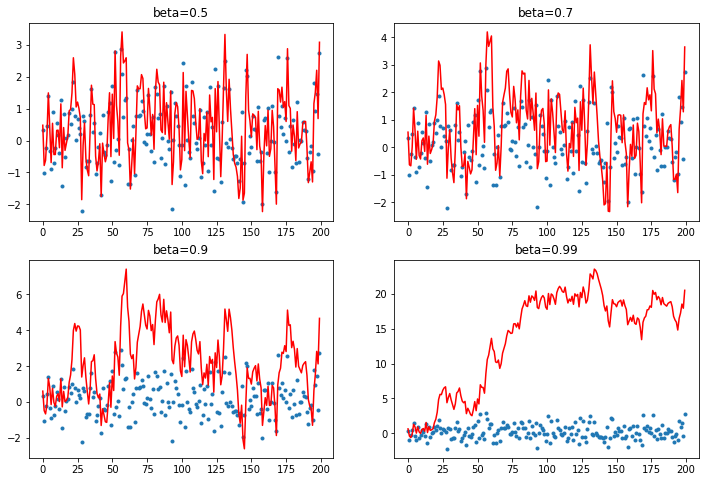

In [54]:
def mom1(avg, beta, yi, i): 
    if avg is None: avg=yi
    res = beta*avg + yi # moving_grad*mom + current grad_w
    return res,res
plot_mom(mom1)

Since current value always has 100% weight, the moving avg will shoot up high if some data point is big enough 

### Smoothened momentum

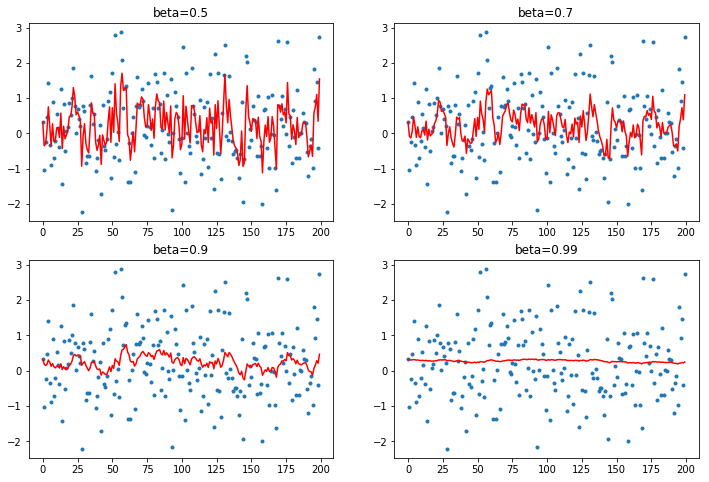

In [55]:
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    avg = lin_comb(avg, yi, beta) # moving_grad*mom + current_gradw*(1-mom)
    return avg, avg
plot_mom(mom2)

Smoothened moving average will have a certain shape when data has that shape

In [56]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1
y[0]=0.5

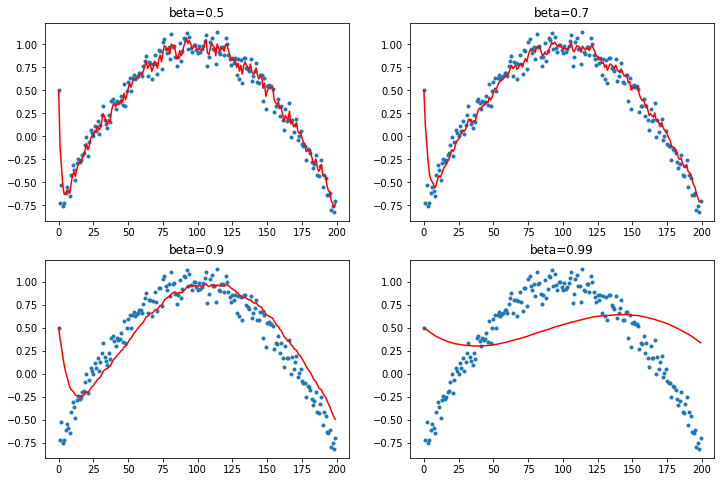

In [57]:
plot_mom(mom2)

Quick look at 4th graph: with a high outlier at the beginning and high momentum (.99), the moving avg struggles to adjust to sudden change (the following low data)

Comparing to the 'regular' momentum where high data point (middle part, and current values get 100% weight) results in higher moving average

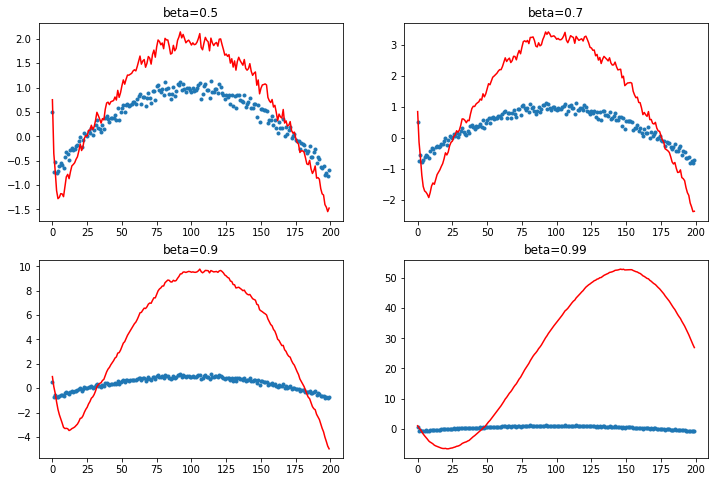

In [58]:
plot_mom(mom1)

### Adding debiasing

To correct wrong information we may have in the very first batch

<p>$\begin{align*}
avg_{i} &amp;= \beta\ avg_{i-1} + (1-\beta)\ v_{i} = \beta\ (\beta\ avg_{i-2} + (1-\beta)\ v_{i-1}) + (1-\beta)\ v_{i} \\
&amp;= \beta^{2}\ avg_{i-2} + (1-\beta)\ \beta\ v_{i-1} + (1-\beta)\ v_{i} \\
&amp;= \beta^{3}\ avg_{i-3} + (1-\beta)\ \beta^{2}\ v_{i-2} + (1-\beta)\ \beta\ v_{i-1} + (1-\beta)\ v_{i} \\
&amp;\vdots \\
&amp;= (1-\beta)\ \beta^{i}\ v_{0} + (1-\beta)\ \beta^{i-1}\ v_{1} + \cdots + (1-\beta)\ \beta^{2}\ v_{i-2} + (1-\beta)\ \beta\  v_{i-1} + (1-\beta)\ v_{i}
\end{align*}$</p>


Sum of coefficient when we write the full formula of moving average (with β as momentum)

<p>$\begin{align*}
S =(1-\beta)\ \beta^{i} + (1-\beta)\ \beta^{i-1} + \cdots + (1-\beta)\ \beta^{2} + (1-\beta)\ \beta + (1-\beta) \\
S = (\beta^{i} - \beta^{i+1}) + (\beta^{i-1} - \beta^{i}) + \cdots + (\beta^{2} - \beta^{3}) + (\beta - \beta^{2}) + (1-\beta) \\
S = 1 - \beta^{i+1}
\end{align*}$</p>


By dividing by this term, we make our moving average a true average (in the sense that all the coefficients we used for the average sum up to 1).

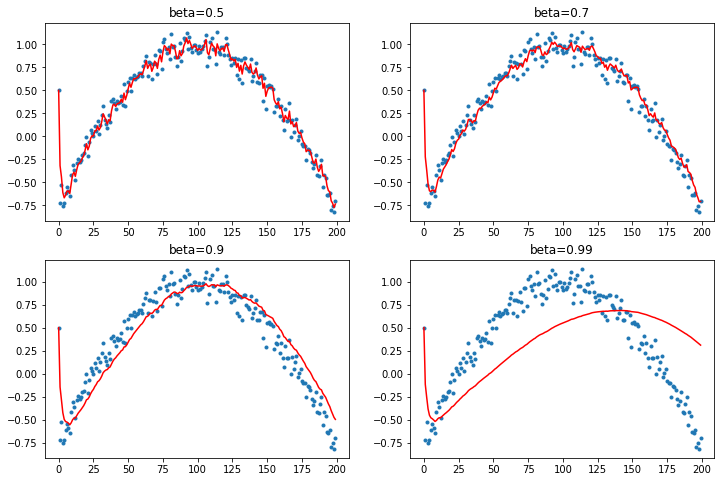

In [59]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

With debiasing, high outlier will be averaged out. Moving avg are quicker to adjust to sudden change (high bias followed by low data)

# Adam and others

We will stick with smoothened moving average of weight gradient, and also add the 'square moving average'

Stat class example (reference)

```python
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data) 
        # moving_grad = moving_grad*mom + current_gradw 
        # note that this is the 'regular' momentum where current_gradw has 100% weight, 
        # not the 'smoothened' one with  (1-mom)*current_gradw
        return state

def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg) # p.data= p.data+ lr*moving_grad
    return p
```

In [60]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
#         moving_grad = moving_grad*mom + (1-mom)*current_gradw
        return state

torch.addcmul(tensor, value=1, tensor1, tensor2, out=None)

-> out = tensor + value * tensor1 * tensor2

In [61]:
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        # moving_grad_sqr = moving_grad_sqr*mom + (1-mom)*current_gradw*current_gradw
        return state

In [62]:
# number of steps done during training for the debiasing.
class StepCount(Stat):
    def init_state(self, p): return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

In [63]:
# helper function for debias. About the (1-mom) in the denominator:
# If we dampening, damp = 1 - mom and they cancel out
# If we don't use dampening, (damp = 1) we will need to divide by 1 - mom because that term is missing everywhere.
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

In [64]:
def adam_step(p, lr, mom, mom_damp, step, 
                sqr_mom, sqr_damp, 
                grad_avg, sqr_avg, # this is from **state, passed in compose function in StatefulOptimizer step()
                eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    # p.data = p.data + (-lr) * (grad_avg/debias1) / ( sqrt(sqr_avg/debias2) + e )
    return p
adam_step._defaults = dict(eps=1e-5)

In [65]:
# wrapper for StatefulOptimizer class
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step,weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [68]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func=adam_opt())

In [69]:
run.fit(3, learn)

train: [1.7653983926632542, tensor(0.3924, device='cuda:0')]
valid: [1.39425537109375, tensor(0.5500, device='cuda:0')]
train: [1.2797790214925546, tensor(0.5792, device='cuda:0')]
valid: [1.1503714599609376, tensor(0.6120, device='cuda:0')]
train: [1.0037304626909802, tensor(0.6743, device='cuda:0')]
valid: [1.0825418701171876, tensor(0.6500, device='cuda:0')]


# LAMP optimizer

https://arxiv.org/pdf/1904.00962.pdf

$\begin{align}
g_{t}^{l} &= \nabla L(w_{t-1}^{l}, x_{t}) \\
m_{t}^{l} &= \beta_{1} m_{t-1}^{l} + (1-\beta_{1}) g_{t}^{l} \\
v_{t}^{l} &= \beta_{2} v_{t-1}^{l} + (1-\beta_{2}) g_{t}^{l} \odot g_{t}^{l} \\
m_{t}^{l} &= m_{t}^{l} / (1 - \beta_{1}^{t}) \\
v_{t}^{l} &= v_{t}^{l} / (1 - \beta_{2}^{t}) \\
\end{align}$

So far we are just doing Adam opt with dampening + debias

$\begin{align}
s_{t}^{l} &= \frac{m_{t}^{l}}{\sqrt{v_{t}^{l} + \epsilon}} + \lambda w_{t-1}^{l} \\ 
\end{align}$

Adding regular weight decay (we will call this Adam_step)

$\begin{align}
r_{1} &= \|w_{t-1}^{l}\|_{2} \\
r_{2} &= \| s_{t}^{l} \|_{2} \\
\eta^{l} &= \eta * r_{1}/r_{2} \\ 
w_{t}^{l} &= w_{t}^{l-1} - \eta_{l} * s_{t}^{l} \\
\end{align}$

We now have a new scalar value: r1/r2 or norm(layer_weight) / norm(Adam_step) and this will be part of the new learning rate

Essentially we average the Adam_step over a layer. We normalize Adam_step by dividing it by its norm, then multiply the whole thing by layer weight's norm

In [70]:

def lamb_step(p, lr, mom, mom_damp, step, 
              sqr_mom, sqr_damp, 
              grad_avg, sqr_avg, eps, 
              wd, #new
              **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
       
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
   
    r1 = p.data.pow(2).mean().sqrt() # weight (p.data) norm, shape (1,)
    r2 = step.pow(2).mean().sqrt() # step norm, shape (1,)
    p.data.add_(-lr * min(r1/r2,10), step)# TODO ???
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [71]:
lamb = partial(StatefulOptimizer, 
               steppers=lamb_step, 
               stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [74]:
cbfs

[functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7fdc75a7d268>),
 exp.nb_06.CudaCallback]

In [77]:
learn,run = get_learn_run(nfs, data, 0.003, conv_layer, cbs=cbfs, opt_func=lamb)

In [78]:
run.fit(3, learn)

train: [1.8681699700442067, tensor(0.3499, device='cuda:0')]
valid: [1.485524169921875, tensor(0.4960, device='cuda:0')]
train: [1.338618010314875, tensor(0.5587, device='cuda:0')]
valid: [1.287728759765625, tensor(0.5500, device='cuda:0')]
train: [1.0558921088539244, tensor(0.6591, device='cuda:0')]
valid: [1.1565224609375, tensor(0.6060, device='cuda:0')]
